<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

#GLMs para Codificación

---
# Objetivos

El objetivo es modelar un tren de disparos de una célula ganglionar de la retina ajustando un campo receptivo temporal. Primero con un GLM Lineal-Gaussiano (también conocido como modelo de regresión de mínimos cuadrados ordinarios) y luego con un GLM de Poisson (también conocido como modelo "Lineal-No Lineal-Poisson").

Este notebook está diseñado para ejecutarse con datos de trenes de espigas de células ganglionares de la retina de [Uzzell & Chichilnisky 2004](https://journals.physiology.org/doi/full/10.1152/jn.01171.2003?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed).


---
# Configuración

##  Instalar e importar gadget de retroalimentación

In [1]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D3_T1"

In [2]:
# Importaciones
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat

##  Configuraciones de las figuras


In [3]:
# @title Configuraciones de las figuras
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Funciones para Graficar



In [5]:
# @title Funciones para Graficar

def plot_stim_and_spikes(stim, spikes, dt, nt=120):
  """Mostrar series temporales de intensidad de estímulo y conteo de espigas.

  Args:
  stim (array 1D): vector de intensidades de estímulo
  spikes (array 1D): vector de conteo de espigas
  dt (número): duración de cada paso de tiempo
  nt (número): número de pasos de tiempo a graficar

  """
  timepoints = np.arange(nt)
  time = timepoints * dt

  f, (ax_stim, ax_spikes) = plt.subplots(
    nrows=2, sharex=True, figsize=(8, 5),
  )
  ax_stim.plot(time, stim[timepoints])
  ax_stim.set_ylabel('Stimulus intensity')

  ax_spikes.plot(time, spikes[timepoints])
  ax_spikes.set_xlabel('Time (s)')
  ax_spikes.set_ylabel('Number of spikes')

  f.tight_layout()
  plt.show()


def plot_glm_matrices(X, y, nt=50):
  """Mostrar X y Y como mapas de calor.

  Args:
  X (array 2D): Matriz de diseño.
  y (array 1D o 2D): Vector objetivo.

  """
  from matplotlib.colors import BoundaryNorm
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  Y = np.c_[y]  # Ensure Y is 2D and skinny

  f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(6, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )
  norm = BoundaryNorm([-1, -.2, .2, 1], 256)
  imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)

  ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    xticks=[4, 14, 24],
    xticklabels=['-20', '-10', '0'],
    ylabel="Time point (time bins)",
  )
  plt.setp(ax_x.spines.values(), visible=True)

  divx = make_axes_locatable(ax_x)
  caxx = divx.append_axes("right", size="5%", pad=0.1)
  cbarx = f.colorbar(imx, cax=caxx)
  cbarx.set_ticks([-.6, 0, .6])
  cbarx.set_ticklabels(np.sort(np.unique(X)))

  norm = BoundaryNorm(np.arange(y.max() + 1), 256)
  imy = ax_y.pcolormesh(Y[:nt], cmap="magma", norm=norm)
  ax_y.set(
    title="Y\n(spike count)",
    xticks=[]
  )
  ax_y.invert_yaxis()
  plt.setp(ax_y.spines.values(), visible=True)

  divy = make_axes_locatable(ax_y)
  caxy = divy.append_axes("right", size="30%", pad=0.1)
  cbary = f.colorbar(imy, cax=caxy)
  cbary.set_ticks(np.arange(y.max()) + .5)
  cbary.set_ticklabels(np.arange(y.max()))
  plt.show()


def plot_spike_filter(theta, dt, show=True, **kws):
  """Graficar los pesos estimados basados en el modelo de retraso de tiempo.

  Args:
  theta (array 1D): Pesos del filtro, sin incluir el término DC.
  dt (número): Duración de cada bine de tiempo.
  kws: Pasar argumentos de palabras clave adicionales a plot()
  show (booleano): Mostrar o no la gráfica.
  """
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )
  if show:
    plt.show()


def plot_spikes_with_prediction(spikes, predicted_spikes, dt,
                                nt=50, t0=120, **kws):
  """Graficar conteos de espigas reales y predichos.

  Args:
  spikes (array 1D): Vector de conteos de espigas reales
  predicted_spikes (array 1D): Vector de conteos de espigas predichos
  dt (número): Duración de cada bine de tiempo.
  nt (número): Número de bines de tiempo a graficar
  t0 (número): Índice del primer bine de tiempo a graficar.
  show (booleano): Mostrar o no la gráfica.
  kws: Pasar argumentos de palabras clave adicionales a plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt])
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])
  plt.show()

##  Recuperación y carga de datos

In [7]:
# @title Recuperación y carga de datos

import os
import hashlib
import requests

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

---
# Sección 1: GLM Lineal-Gaussiano

## Sección 1.1: Cargar datos de actividad de células ganglionares de la retina

En este ejercicio utilizamos datos de un experimento que presentó una pantalla que alternaba aleatoriamente entre dos valores de luminancia y registró respuestas de células ganglionares de la retina (CGR), un tipo de neurona en la retina en la parte posterior del ojo. Este tipo de estímulo visual se llama "parpadeo de campo completo" y se presentó a ~120Hz (es decir, el estímulo en la pantalla se actualizaba aproximadamente cada 8 ms). Estos mismos intervalos de tiempo se utilizaron para contar el número de espigas emitidas por cada neurona.

El archivo `RGCdata.mat` contiene tres variables:

- `Stim`, la intensidad del estímulo en cada punto de tiempo. Es un arreglo con forma $T \times 1$, donde $T=144051$.

- `SpCounts`, los conteos de espigas agrupados para 2 células ON y 2 células OFF. Es un arreglo de $144051 \times 4$, y cada columna tiene conteos para una célula diferente.

- `dtStim`, el tamaño de un único intervalo de tiempo (en segundos), que se necesita para calcular la salida del modelo en unidades de espigas / s. La tasa de fotogramas del estímulo se da por `1 / dtStim`.

Dado que estos datos se guardaron en MATLAB, donde todo es una matriz, también procesaremos las variables a representaciones más propias de Python (arreglos 1D o escalares, donde sea apropiado) a medida que cargamos los datos.

In [8]:
data = loadmat('RGCdata.mat')  # loadmat is a function in scipy.io
dt_stim = data['dtStim'].item()  # .item extracts a scalar value

# Extract the stimulus intensity
stim = data['Stim'].squeeze()  # .squeeze removes dimensions with 1 element

# Extract the spike counts for one cell
cellnum = 2
spikes = data['SpCounts'][:, cellnum]

# Don't use all of the timepoints in the dataset, for speed
keep_timepoints = 20000
stim = stim[:keep_timepoints]
spikes = spikes[:keep_timepoints]

Utiliza la función de ayuda `plot_stim_and_spikes` para visualizar los cambios en las intensidades del estímulo y los conteos de espigas a lo largo del tiempo.

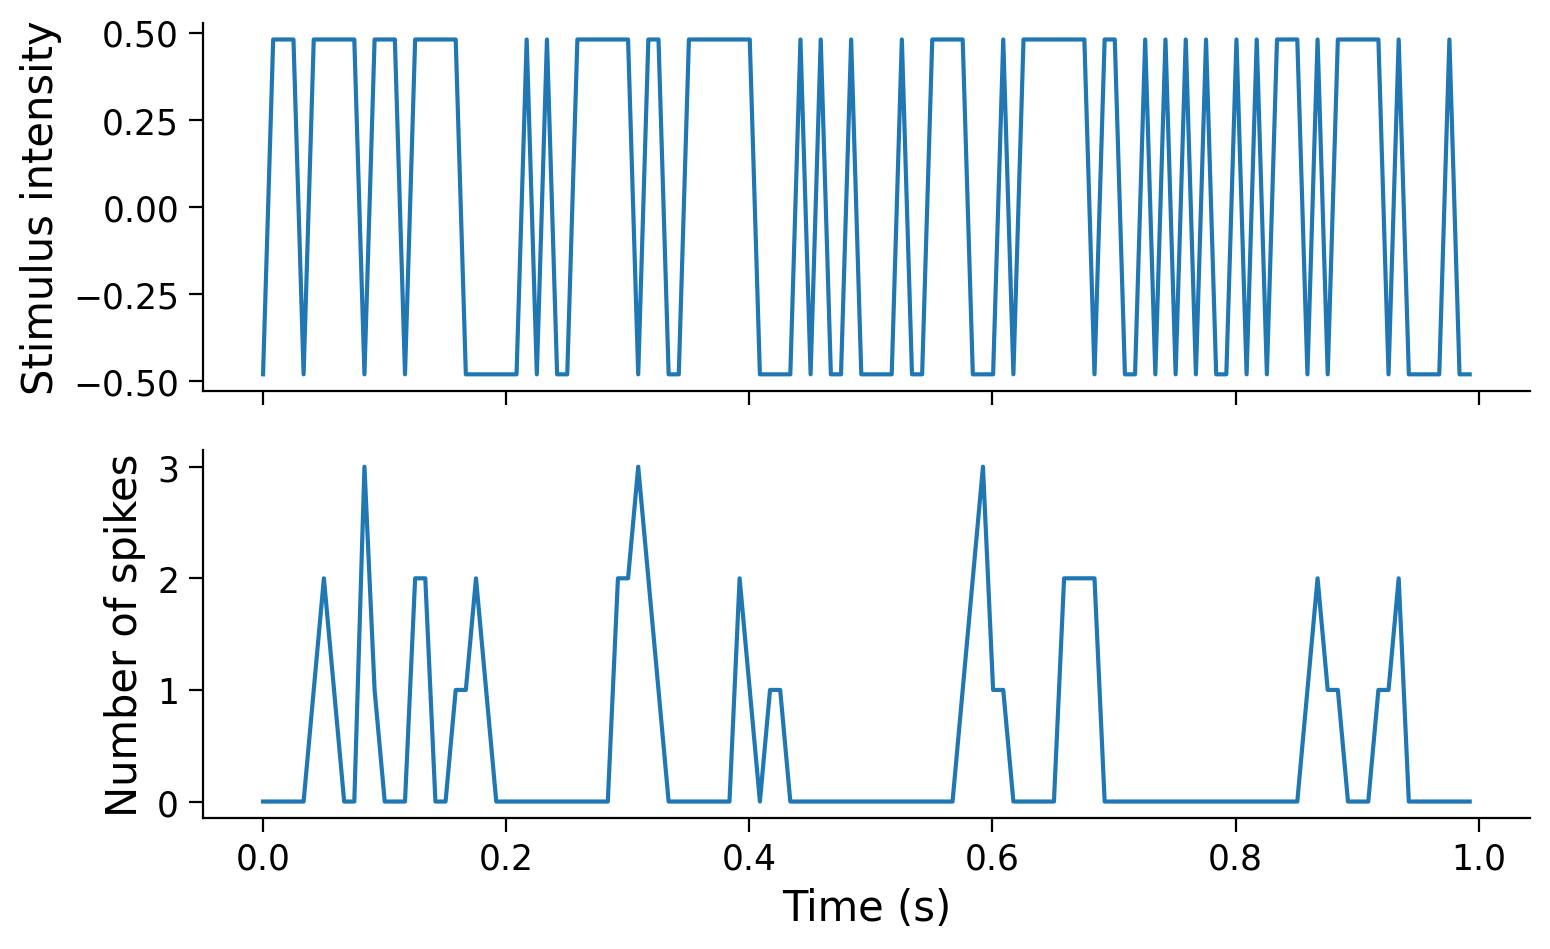

In [9]:
plot_stim_and_spikes(stim, spikes, dt_stim)

### Ejercicio de Programación 1.1: Crear la matriz de diseño

Nuestro objetivo es predecir la actividad de la célula a partir de las intensidades del estímulo que la preceden. Esto nos ayudará a entender cómo las CGR procesan la información a lo largo del tiempo. Para hacerlo, primero necesitamos crear la *matriz de diseño* para este modelo, que organiza las intensidades del estímulo en forma de matriz de modo que la fila $i$ tenga los marcos de estímulo anteriores al punto de tiempo $i$.

Vamos a crear la matriz de diseño $\mathbf{X}$ usando $d=25$ retardos temporales. Es decir, $\mathbf{X}$ debería ser una matriz de $T \times d$. $d = 25$ (aproximadamente 200 ms) es una elección que estamos haciendo basada en nuestro conocimiento previo de la ventana temporal que influye en las respuestas de las CGR. En la práctica, podrías no saber la duración correcta a usar.

La última entrada en la fila `t` debe corresponder al estímulo que se mostró en el tiempo `t`, la entrada a la izquierda de ella debe contener el valor que se mostró un intervalo de tiempo antes, etc. Específicamente, $X_{ij}$ será la intensidad del estímulo en el tiempo $i + d - 1 - j$.

Nota que para los primeros intervalos de tiempo, tenemos acceso a los conteos de espigas registrados, pero no al estímulo mostrado en el pasado reciente. Por simplicidad, vamos a asumir que los valores de `stim` son 0 para los retardos temporales anteriores al primer punto de tiempo en el conjunto de datos. Esto se conoce como "relleno de ceros", de modo que la matriz de diseño tenga el mismo número de filas que los vectores de respuesta en `spikes`.

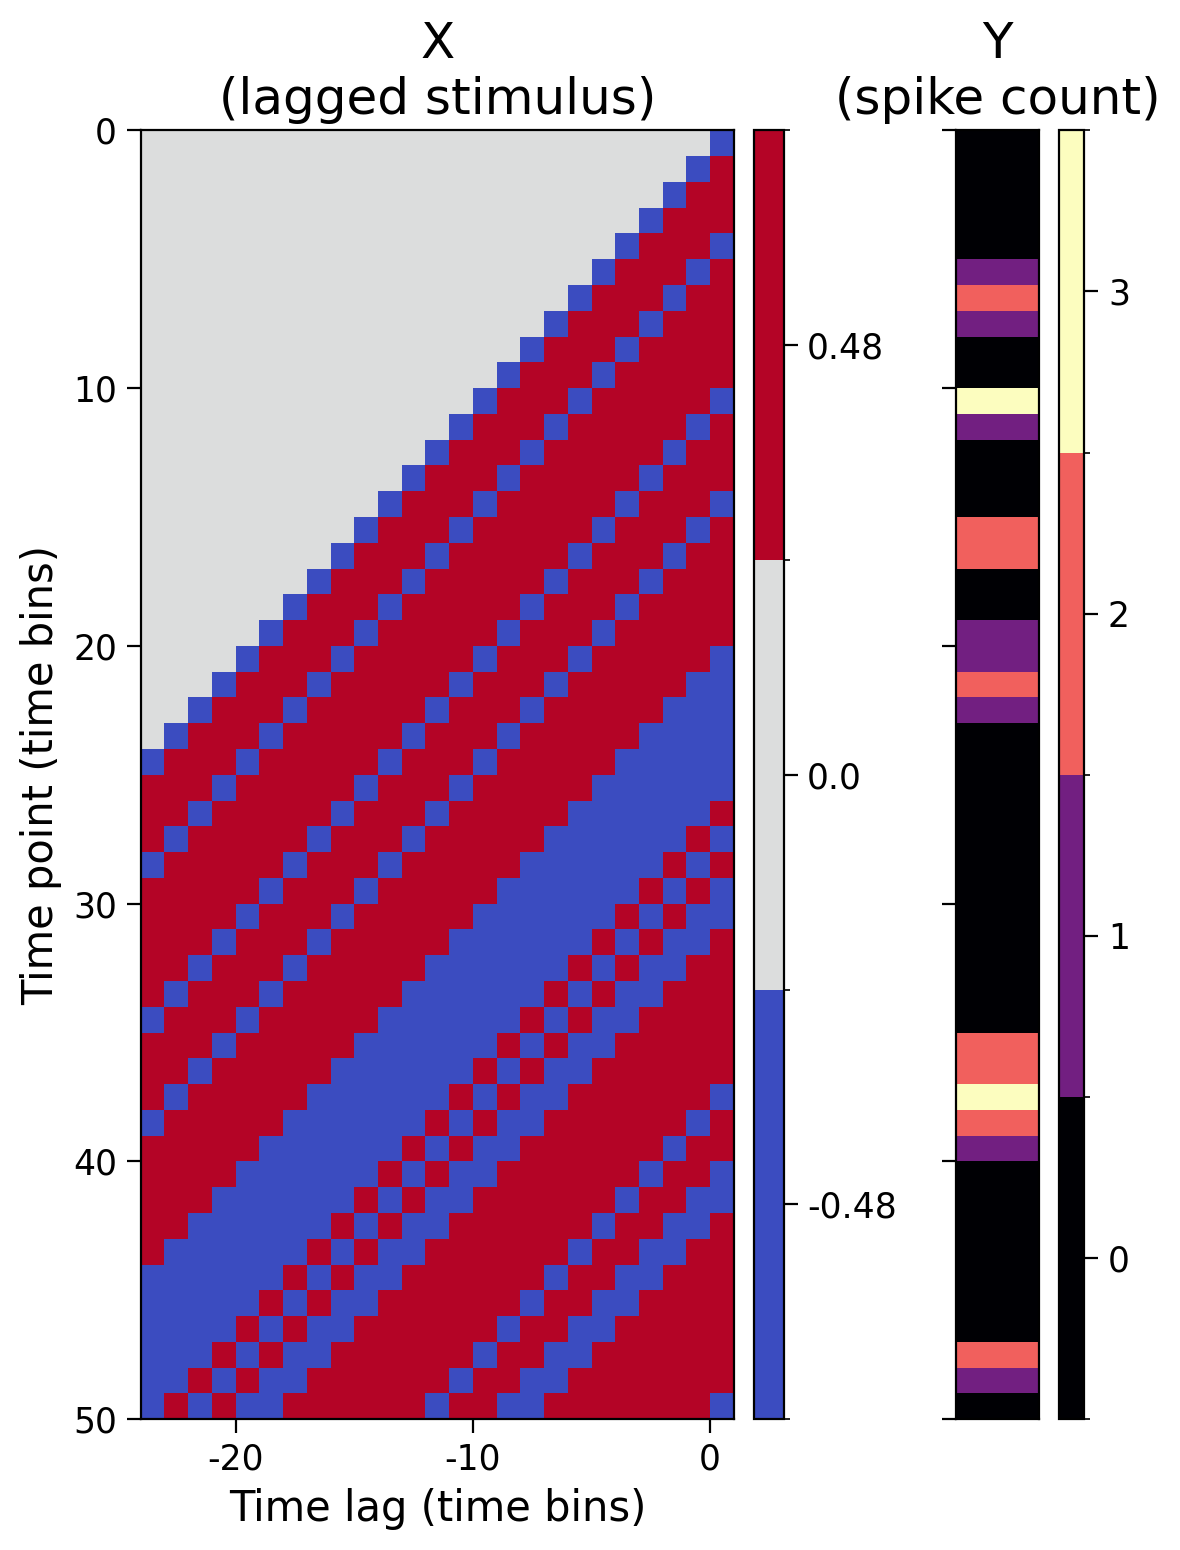

In [ ]:
def make_design_matrix(stim, d=25):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  """
  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  return X


# Make design matrix
X = make_design_matrix(stim)

# Visualize
plot_glm_matrices(X, spikes, nt=50)

## Sección 1.2: Ajustar el modelo de regresión Lineal-Gaussiano

Primero, utilizaremos la matriz de diseño para calcular la estimación de máxima verosimilitud para un GLM Lineal-Gaussiano (también conocido como "modelo lineal general"). La estimación de máxima verosimilitud de $\theta$ en este modelo se puede resolver analíticamente usando la ecuación q

\begin{equation}
\boldsymbol{\hat \theta} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{y}
\end{equation}

Antes de que podamos aplicar esta ecuación, necesitamos aumentar la matriz de diseño para tener en cuenta la media de $y$, ya que los conteos de espigas son todos $\geq 0$. Hacemos esto añadiendo una columna constante de 1's a la matriz de diseño, lo que permitirá al modelo aprender un peso de desplazamiento aditivo. Nos referiremos a este peso adicional como $b$ (por sesgo), aunque alternativamente se le conoce como "término DC" o "intercepción".

In [ ]:
# Build the full design matrix
y = spikes
constant = np.ones_like(y)
X = np.column_stack([constant, make_design_matrix(stim)])

# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta_lg = theta[1:]

Gráfico de la estimación del filtro de máxima verosimilitud resultante (solo el vector de peso de 25 elementos $\theta$ sobre los elementos del estímulo, no el término DC $b$).

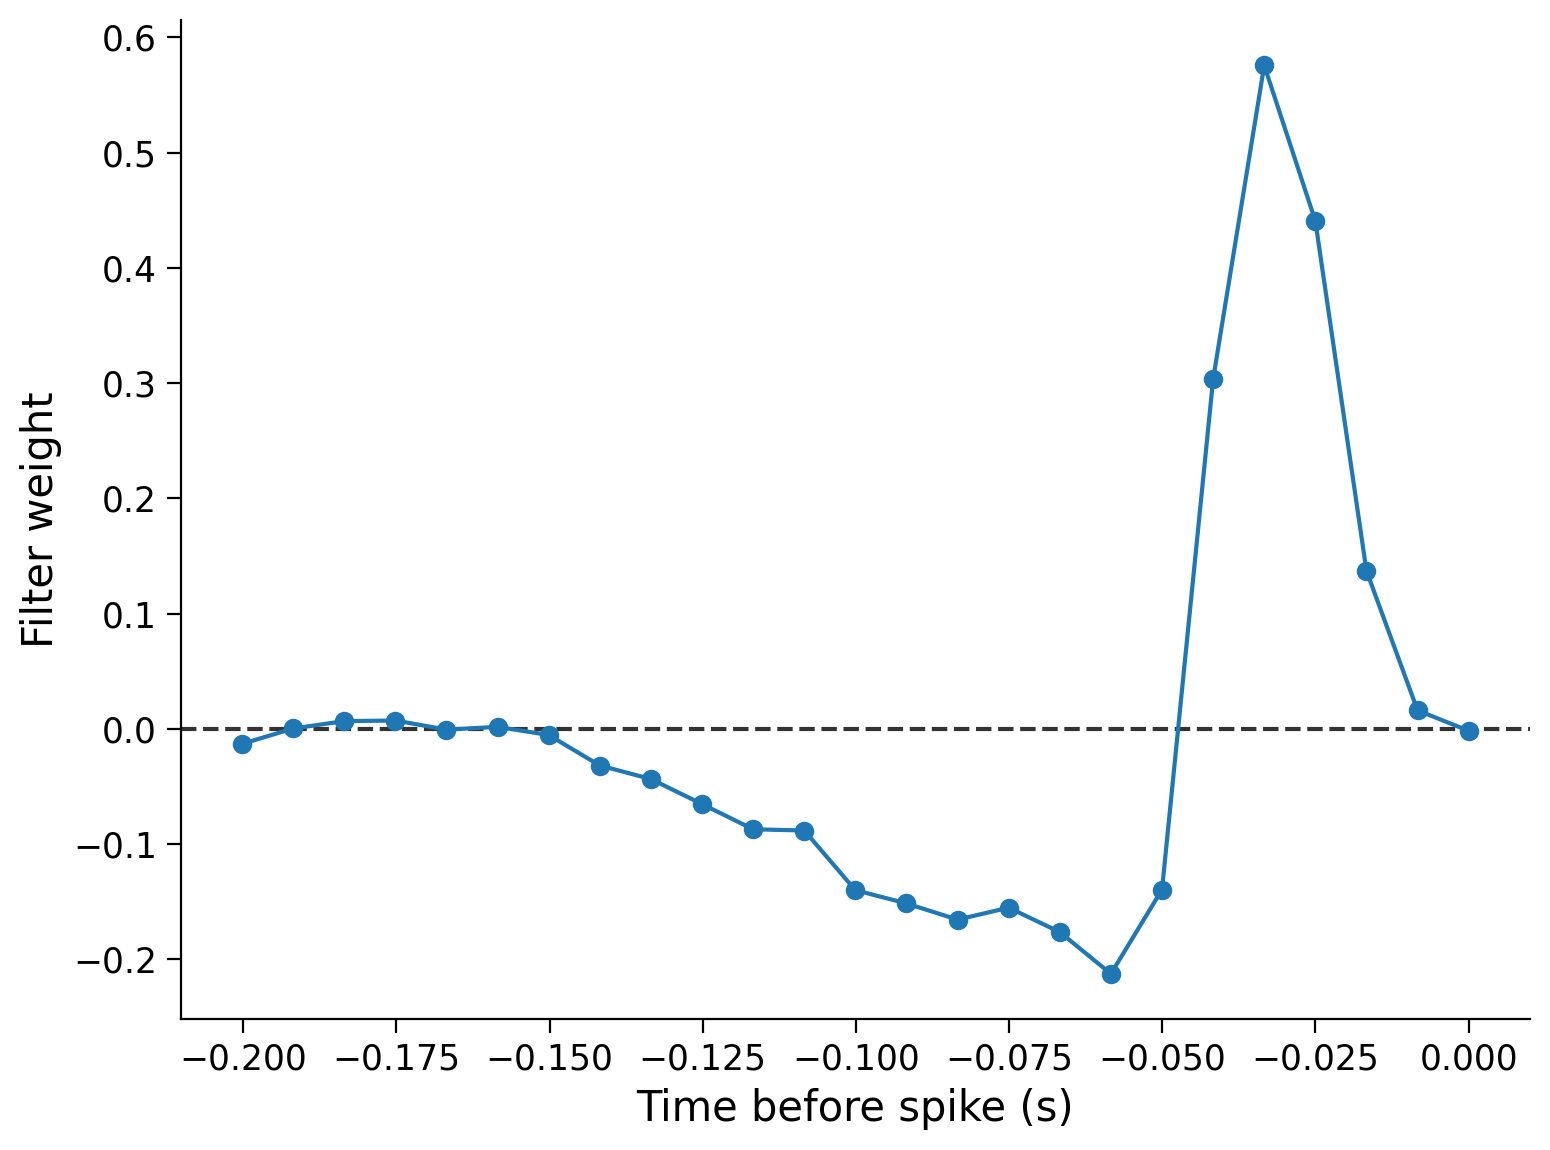

In [ ]:
plot_spike_filter(theta_lg, dt_stim)

### Sección 1.3: Predecir conteos de espigas con el modelo Lineal-Gaussiano

Ahora vamos a juntar estas piezas y escribir una función que proporcione un conteo de espigas predicho para cada punto de tiempo usando la información del estímulo.

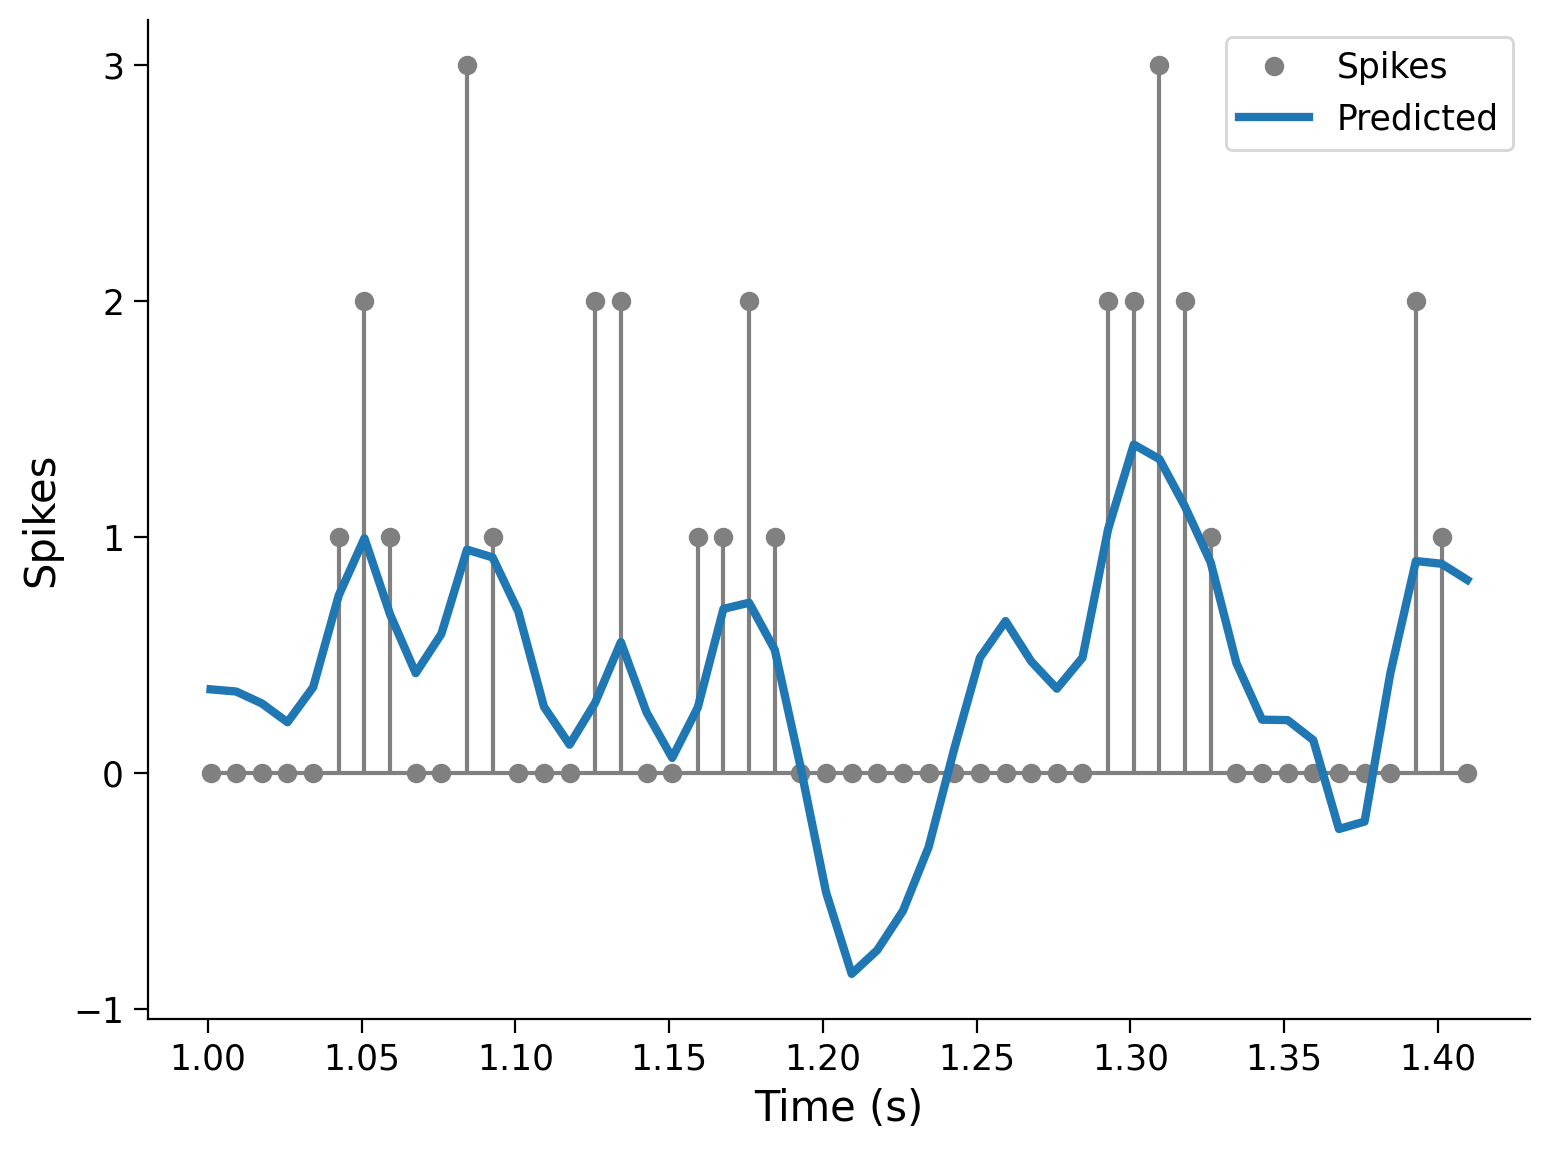

In [ ]:
def predict_spike_counts_lg(stim, spikes, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """

  # Create the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Get the MLE weights for the LG model
  theta = np.linalg.inv(X.T @ X) @ X.T @ y

  # Compute predicted spike counts
  yhat = X @ theta

  return yhat


# Predict spike counts
predicted_counts = predict_spike_counts_lg(stim, spikes)

# Visualize
plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)

¿Es este un buen modelo? La línea de predicción más o menos sigue los picos en las espigas, pero nunca predice tantas espigas como se observan en realidad. Y, lo que es más problemático, está prediciendo espigas *negativas* en algunos puntos de tiempo.

El GLM de Poisson ayudará a abordar estas fallas.

---
# Sección 2: GLM Lineal-No Lineal-Poisson


## Sección 2.1: Optimización no lineal con `scipy.optimize`

Ahora vamos a aplicar un GLM no lineal con distribución de Poisson y compararlo con el resultado anterior. Tengamos en cuenta que o hay una solución analítica para la ecuación que nos define el mínimo de nuestra verosimilitud. Por eso, vamos a aplicar un algoritmo de optimización no lineal para encontrar los valores de los parámetros que minimicen alguna *función objetivo*.

El módulo `scipy.optimize` contiene una función llamada [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) que proporciona una interfaz genérica a una gran cantidad de algoritmos de optimización. Esta función espera como argumento una función objetivo y una "estimación inicial" para los valores de los parámetros. Luego devuelve un diccionario que incluye el valor mínimo de la función, los parámetros que dan este mínimo y otra información.

Veamos cómo funciona esto con un ejemplo sencillo. Queremos minimizar la función $f(x) = x^2$:

In [ ]:
f = np.square
res = minimize(f, x0=2)
print(f"Minimum value: {res['fun']:.4g} at x = {res['x'].item():.5e}")

Minimum value: 3.566e-16 at x = -1.88846e-08


Cuando se minimiza $f(x) = x^2$, obtenemos un valor mínimo de $f(x) \approx 0$ cuando $x \approx 0$. El algoritmo no devuelve exactamente $0$, porque se detiene cuando llega lo "suficientemente cerca" de un mínimo. Puedes cambiar el parámetro `tol` para controlar cómo define "lo suficientemente cerca".

Un punto sobre el código merece énfasis. El primer argumento de `minimize` no es un número ni una cadena, sino una *función*. Acá, usamos `np.square`. Está función es particular porque sólo tiene un mínimo, que además es global, entonces nos garantizamos que siempre terminaremos en el mismo

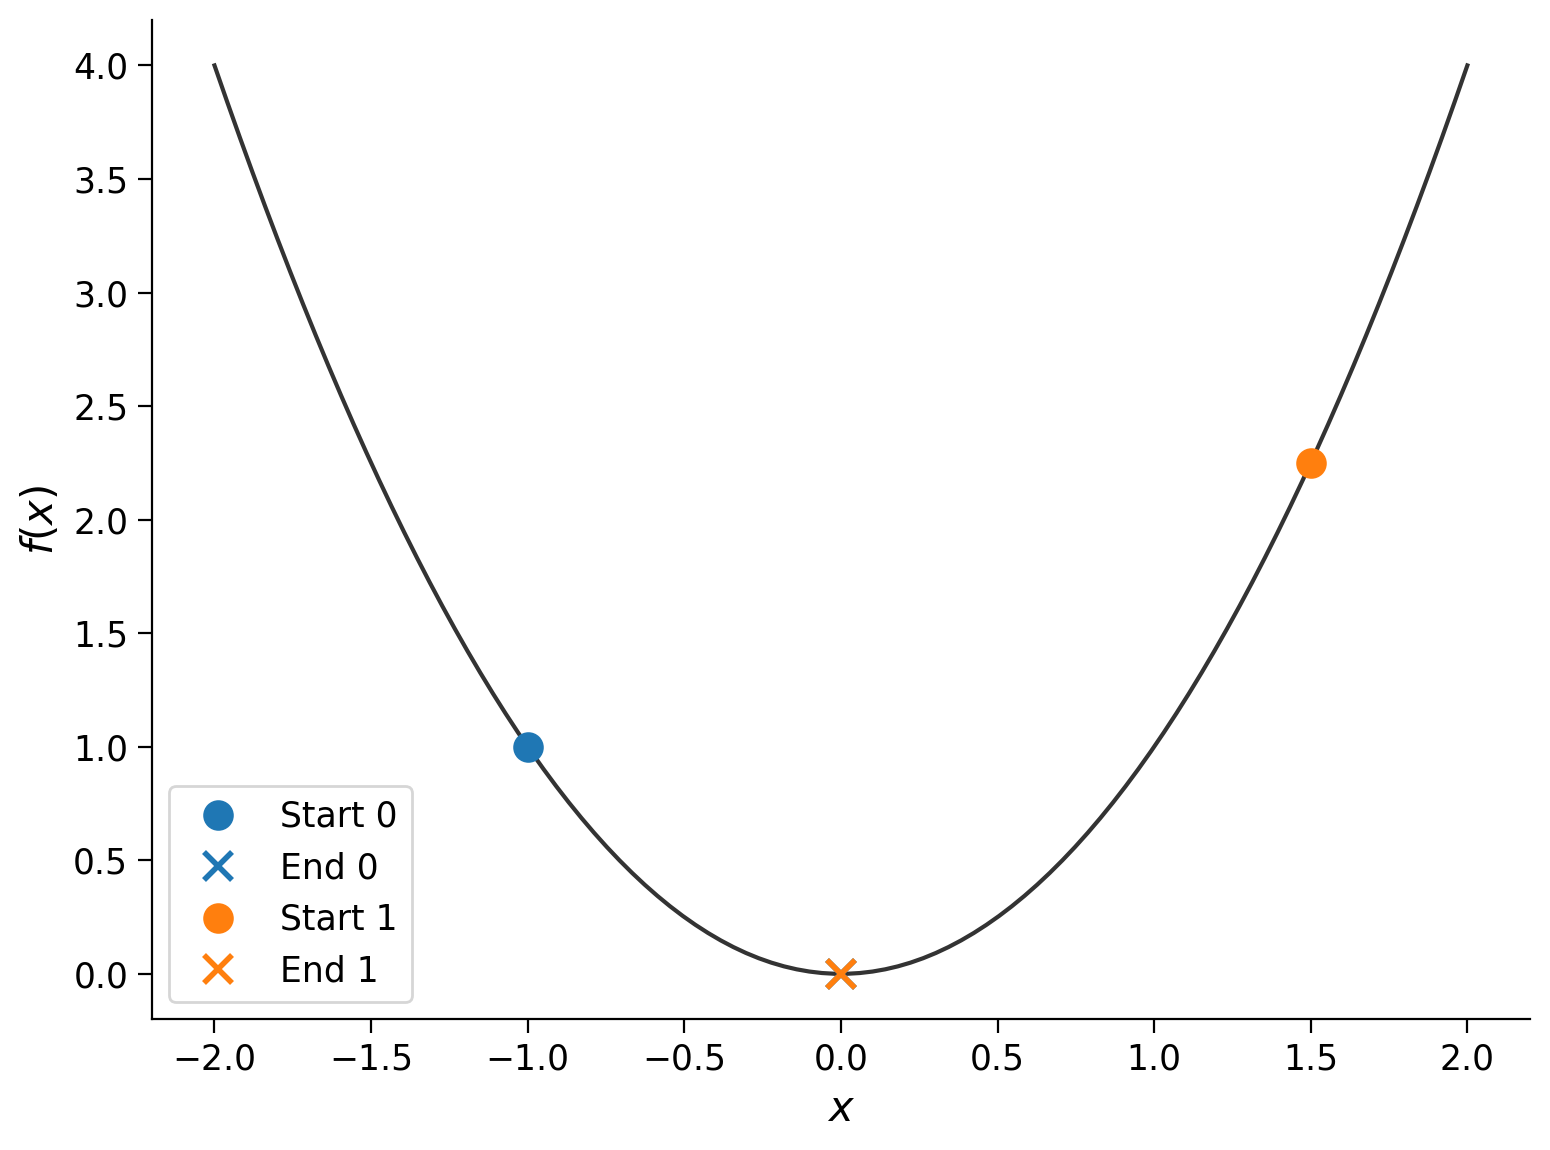

In [ ]:
start_points = -1, 1.5

xx = np.linspace(-2, 2, 100)
plt.plot(xx, f(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(f, x0)
  plt.plot(x0, f(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", c=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

Las ejecuciones comenzaron en diferentes puntos (los puntos), pero cada una terminó aproximadamente en el mismo lugar (la cruz): $f(x_\textrm{final}) \approx 0$. Veamos qué sucede si usamos una función diferente:

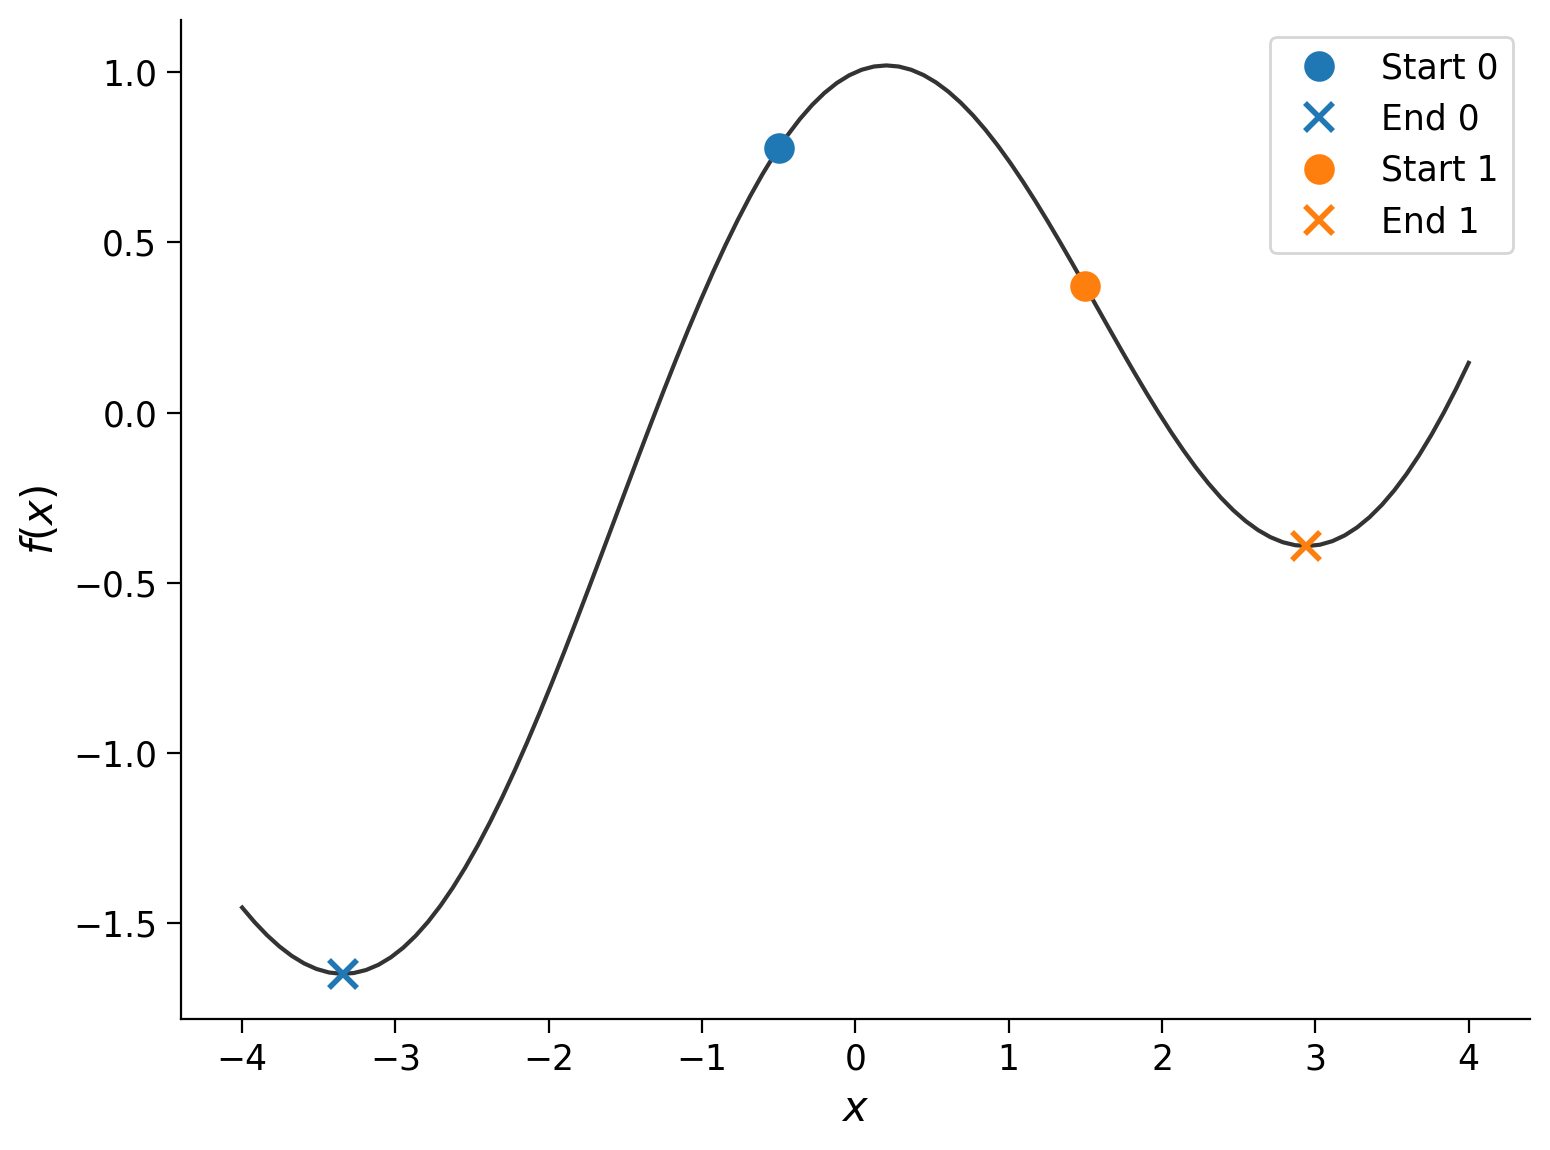

In [ ]:
g = lambda x: x / 5 + np.cos(x)
start_points = -.5, 1.5

xx = np.linspace(-4, 4, 100)
plt.plot(xx, g(xx), color=".2")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

for i, x0 in enumerate(start_points):
  res = minimize(g, x0)
  plt.plot(x0, g(x0), "o", color=f"C{i}", ms=10, label=f"Start {i}")
  plt.plot(res["x"].item(), res["fun"], "x", color=f"C{i}",
           ms=10, mew=2, label=f"End {i}")
plt.legend()
plt.show()

A diferencia de $f(x) = x^2$, $g(x) = \frac{x}{5} + \cos(x)$ no es *convexa*. Vemos que la posición final del algoritmo de minimización depende del punto de partida, lo que añade una capa de complejidad a tales problemas.

### Sección 2.1: Ajuste del GLM de Poisson y predicción de disparos

Utilizaremos [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) para calcular las estimaciones de máxima verosimilitud de los pesos del filtro en el modelo GLM de Poisson con una no linealidad exponencial (LNP: Lineal-No Lineal-Poisson).

Nuestra *función objetivo* va a tomar una matriz de diseño, un vector de conteos de espigas y un vector de parámetros. Debería devolver un logaritmo negativo de la verosimilitud.

¿Cómo debería ser la función objetivo? Como ya mostramos en las diapos, queremos que devuelva el logaritmo negativo de la verosimilitud: $-\log P(y \mid \mathbf{X}, \theta).$

En el GLM de Poisson,

\begin{equation}
\log P(\mathbf{y} \mid \mathbf{X}, \theta) = \sum_t \log P(y_t \mid \mathbf{x_t},\theta),
\end{equation}

donde

\begin{equation}
P(y_t \mid \mathbf{x_t}, \theta) = \frac{\lambda_t^{y_t}\exp(-\lambda_t)}{y_t!} \text{, con tasa } \lambda_t = \exp(\mathbf{x_t}^{\top} \theta).
\end{equation}

Ahora, tomando el logaritmo de la verosimilitud para todos los datos obtenemos:

\begin{equation}
\log P(\mathbf{y} \mid X, \theta) = \sum_t( y_t \log\left(\lambda_t) - \lambda_t - \log(y_t !)\right).
\end{equation}

Dado que vamos a minimizar el logaritmo negativo de la verosimilitud con respecto a los parámetros $\theta$, podemos ignorar el último término que no depende de $\theta$. Para una implementación más rápida, reescribamos esto en notación matricial:

\begin{equation}
\mathbf{y}^{\top} \log(\mathbf{\lambda}) - \mathbf{1}^{\top} \mathbf{\lambda} \text{, con tasa } \mathbf{\lambda} = \exp(\mathbf{X} \theta)
\end{equation}

Finalmente, no olvides agregar el signo menos para que tu función devuelva el logaritmo negativo de la verosimilitud.

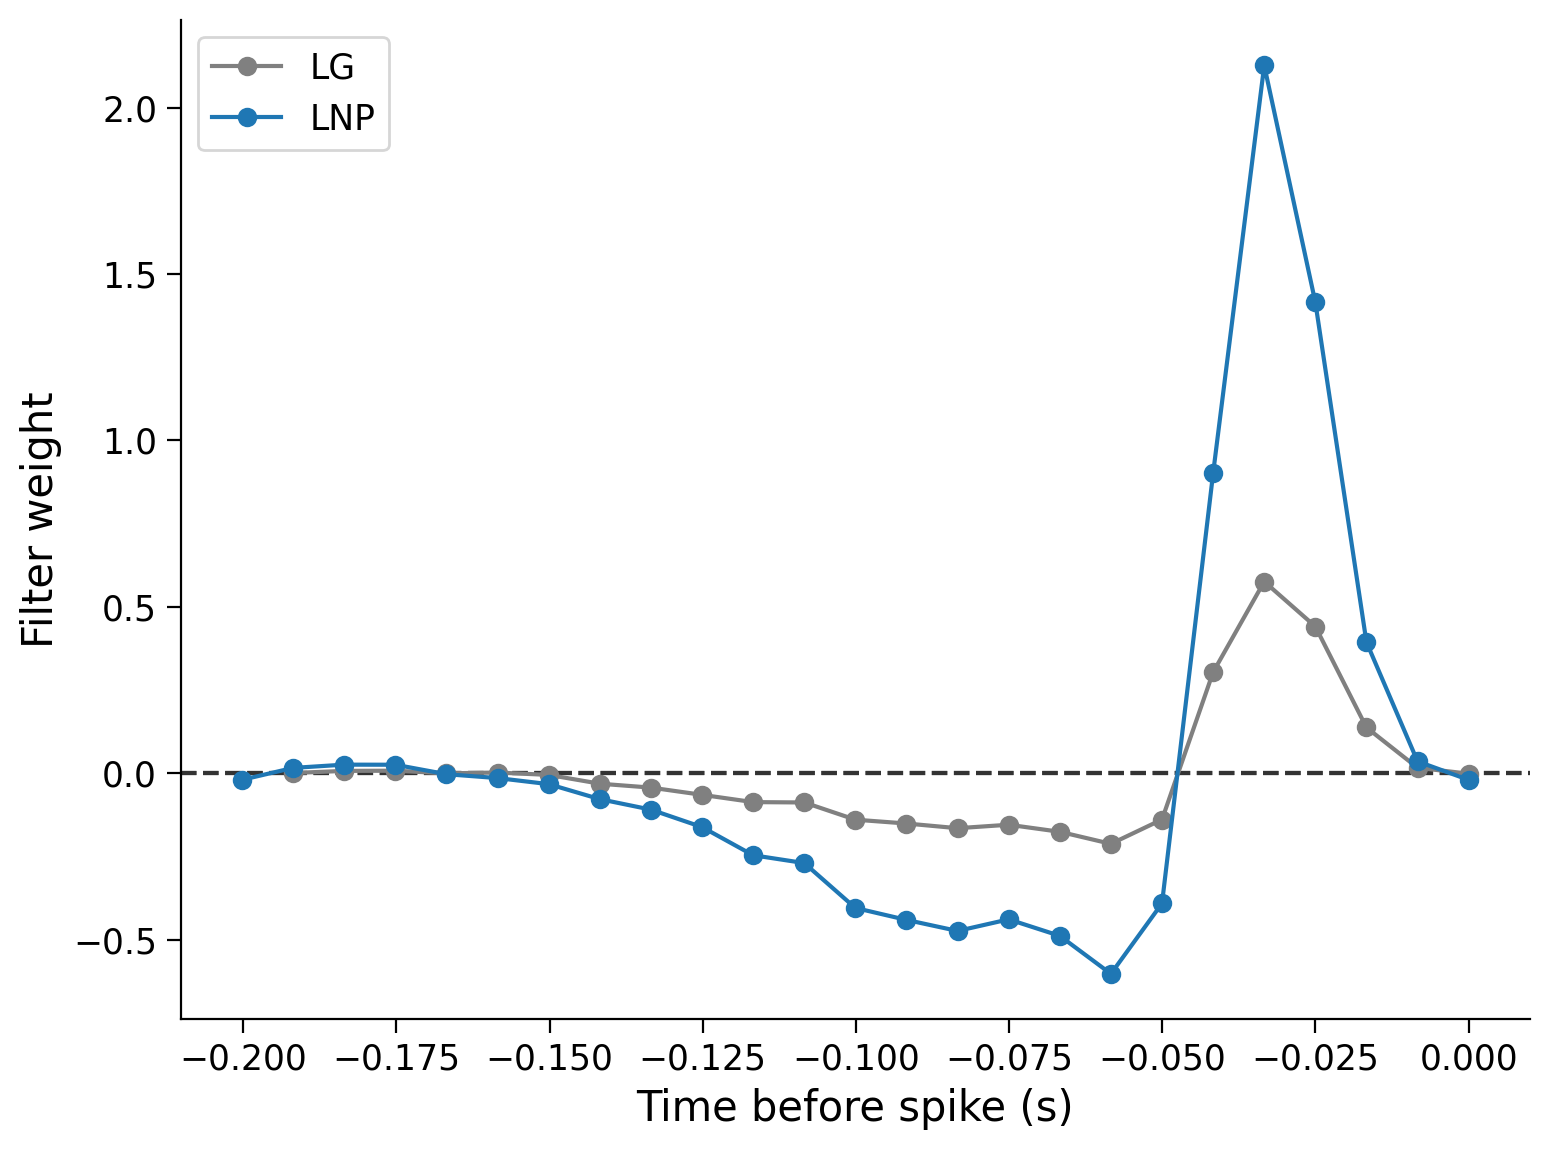

In [ ]:
def neg_log_lik_lnp(theta, X, y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """
  # Compute the Poisson log likelihood
  rate = np.exp(X @ theta)
  log_lik = y @ np.log(rate) - rate.sum()
  return -log_lik


def fit_lnp(stim, spikes, d=25):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """

  # Build the design matrix
  y = spikes
  constant = np.ones_like(y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, y))

  return res["x"]


# Fit LNP model
theta_lnp = fit_lnp(stim, spikes)

# Visualize
plot_spike_filter(theta_lg[1:], dt_stim, show=False, color=".5", label="LG")
plot_spike_filter(theta_lnp[1:], dt_stim, show=False, label="LNP")
plt.legend(loc="upper left")
plt.show()

Al graficar juntos los pesos LG y LNP, vemos que son ampliamente similares, pero los pesos LNP son generalmente más grandes. ¿Qué significa eso para la capacidad del modelo de *predecir* espigas? Para ver eso, terminemos el ejercicio completando la función `predict_spike_counts_lnp`:

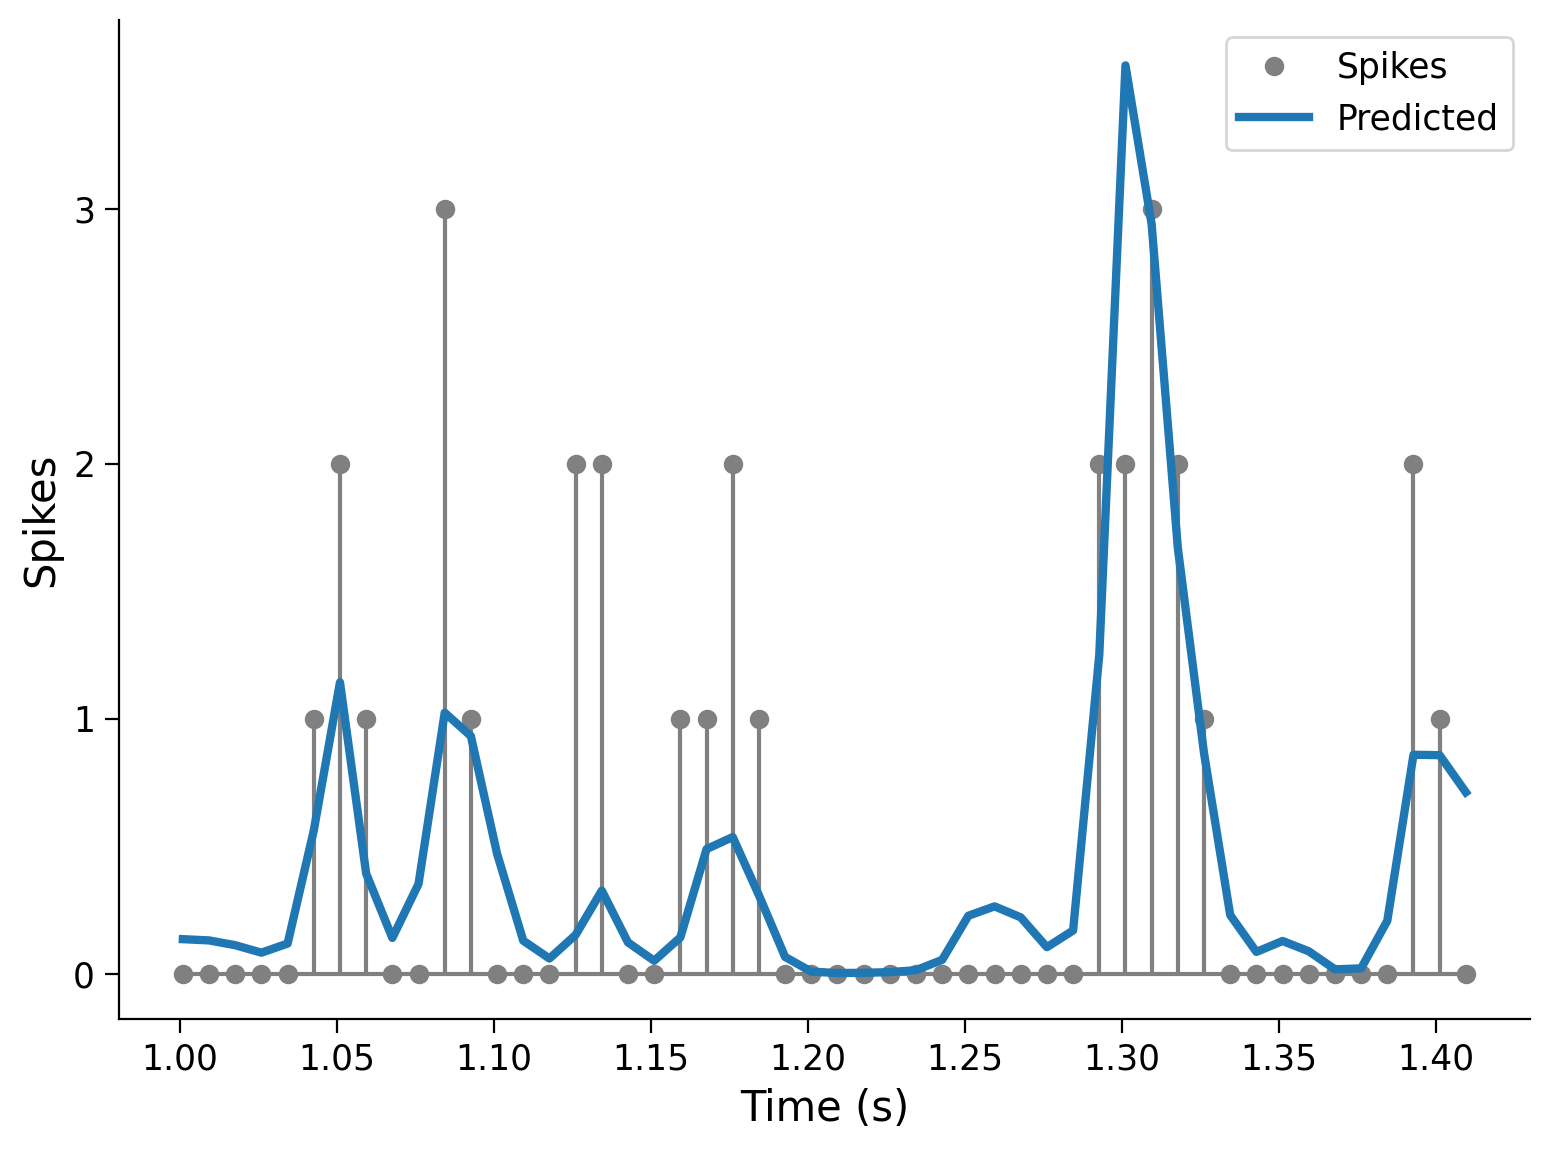

In [ ]:
def predict_spike_counts_lnp(stim, spikes, theta=None, d=25):
  """Compute a vector of predicted spike counts given the stimulus.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    theta (1D array): Filter weights; estimated if not provided.
    d (number): Number of time lags to use.

  Returns:
    yhat (1D array): Predicted spikes at each timepoint.

  """
  y = spikes
  constant = np.ones_like(spikes)
  X = np.column_stack([constant, make_design_matrix(stim)])
  if theta is None:  # Allow pre-cached weights, as fitting is slow
    theta = fit_lnp(X, y, d)

  yhat = np.exp(X @ theta)
  return yhat


# Predict spike counts
yhat = predict_spike_counts_lnp(stim, spikes, theta_lnp)

# Visualize
plot_spikes_with_prediction(spikes, yhat, dt_stim)